# Exploratory Data Analysis (EDA)


# AI Usage Disclosure:
A large language model (LLM) was used to suggest data-cleaning improvements, preprocessing strategies, and code level enhancements for this project.

Parts of this report ,including text polishing, grammar refinement, structural organization, and visual enhancements (such as formatting using backticks ` `, inline code blocks, and other stylistic adjustments) were improved with assistance from a large language model (LLM).

Any code segments that were directly suggested, optimized, or structurally improved by the LLM are explicitly marked with comments inside the scripts.

All core analytical decisions ,including data cleaning logic, statistical reasoning, feature definitions, hypothesis tests, and interpretations were made by me. The LLM did not generate the dataset or perform automated analysis; it served only as a tool for improving clarity, structure, and efficiency of the code.


## 1. Preliminary Steps

### Load and Combine Datasets
This section involves importing necessary Python libraries and loading our core datasets:
- The **box office dataset**, which contains each movie’s production budget, domestic box office, worldwide box office, release year, and related financial metrics.
- The **IMDb / ratings dataset**, which comes from my personal IMDb export and includes fields such as my own rating (`MyRating`), public IMDb rating (`IMDbRatingPublic`), vote counts, and basic title/year information.
- The **awards dataset**, which includes Oscar wins/nominations, total awards and nominations, and other major award indicators for each film.

These datasets are then cleaned, standardized, and merged into a single movie-level dataframe that will be used for the rest of the analysis.




In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)

DATA_DIR = "/content/drive/MyDrive/DSA PROJE DATA/OMDB"

MOJO_PATH    = os.path.join(DATA_DIR, "/content/drive/MyDrive/DSA PROJE DATA/Mojo_budget_update.csv")
RATINGS_PATH = os.path.join(DATA_DIR, "/content/drive/MyDrive/DSA PROJE DATA/e4e94bf3-d679-43d4-acc6-b5676b87f32b.csv")

omdb_paths = [
    os.path.join(DATA_DIR, "omdb_mojo_batch1_enriched.csv"),
    os.path.join(DATA_DIR, "omdb_mojo_batch2_enriched.csv"),
    os.path.join(DATA_DIR, "omdb_mojo_batch3_enriched.csv"),
    os.path.join(DATA_DIR, "omdb_mojo_batch4_enriched.csv"),
]


## 1.2 Basic Cleaning & Column Standardization

In this section, we preprocess all datasets to ensure they are ready for analysis.  
For the **box office dataset**, we standardize all money related fields (such as production budget, domestic gross, and worldwide gross) by removing formatting symbols like `$`, `,`, and whitespace, and then converting them into numeric values. This ensures they can be used in statistical tests and calculations.

For the **OMDb-enriched datasets**, we normalize fields such as IMDb rating, Metascore, genre lists, runtime, and release year. We also apply consistent data types, clean missing values, and concatenate all OMDb batches into a single unified dataframe.

For the **ratings dataset**, we rename columns for consistency (e.g., converting “Your Rating” to `MyRating` and “IMDb Rating” to `IMDbRatingPublic`). We also convert the `Year` column into a numeric nullable integer type and ensure `MyRating` is stored as a numeric value so that correlations and comparisons with public ratings can be performed.

For the **awards dataset**, we extract key award variables such as Oscar wins, Oscar nominations, and total award counts.

Finally, we merge all datasets using shared keys such as `title` and `year`, producing a unified movie dataset suitable for exploratory analysis, hypothesis testing, and machine learning.


In [ ]:
# Load Box Office Mojo data
mojo_df = pd.read_csv(MOJO_PATH)

# Load OMDb enriched batches and concatenate
omdb_dfs = [pd.read_csv(p) for p in omdb_paths]
omdb_df = pd.concat(omdb_dfs, ignore_index=True)

# Load personal IMDb ratings export
ratings_df = pd.read_csv(RATINGS_PATH)

print("Mojo shape:", mojo_df.shape)
print("OMDb shape:", omdb_df.shape)
print("My ratings shape:", ratings_df.shape)


Mojo shape: (3243, 26)
OMDb shape: (3243, 14)
My ratings shape: (833, 14)


In [ ]:
# --- Standardize Mojo columns ---
mojo_df = mojo_df.rename(columns={
    "movie": "Title",
    "Movie": "Title",
    "title": "Title",
    "year": "Year",
    "release_year": "Year",
    "production_budget": "Budget",
    "Production_Budget": "Budget",
    "domestic_gross": "DomesticGross",
    "Domestic_Gross": "DomesticGross",
    "worldwide_gross": "WorldwideGross",
    "Worldwide_Gross": "WorldwideGross"
})

# --- Standardize OMDb columns ---
omdb_df = omdb_df.rename(columns={
    "omdb_title": "Title",
    "omdb_year": "Year",
    "imdbRating": "IMDbRating",
    "Metascore": "Metascore",
    "imdbVotes": "IMDbVotes",
    "Awards": "Awards",
    "BoxOffice": "BoxOffice",
    "imdbID": "imdbID"
})

# Ensure Year is integer where possible
for df in [mojo_df, omdb_df]:
    if "Year" in df.columns:
        df["Year"] = pd.to_numeric(df["Year"], errors="coerce").astype("Int64")
        # Generated with ChatGPT (LLM): convert Year to a numeric nullable integer type; invalid values become NaN.


In [ ]:
def parse_money(x):
    # Generated with ChatGPT (LLM): helper function to clean money fields by removing symbols and converting to numeric.
    if pd.isna(x):
        return np.nan
    x = str(x).strip()
    x = x.replace("$", "").replace(",", "").replace(" ", "")
    return pd.to_numeric(x, errors="coerce")   # Generated with ChatGPT (LLM): safely convert cleaned text to numeric.

money_cols_mojo = ["Budget", "DomesticGross", "WorldwideGross"]
for col in money_cols_mojo:
    if col in mojo_df.columns:
        mojo_df[col] = parse_money(mojo_df[col])   # Generated with ChatGPT (LLM): apply parser to Mojo money columns.

if "BoxOffice" in omdb_df.columns:
    omdb_df["BoxOffice"] = parse_money(omdb_df["BoxOffice"])   # Generated with ChatGPT (LLM): clean OMDb BoxOffice field.


In [ ]:
if "IMDbRating" in omdb_df.columns:
    omdb_df["IMDbRating"] = pd.to_numeric(omdb_df["IMDbRating"], errors="coerce")
    # Generated with ChatGPT (LLM): convert IMDb rating to numeric; invalid entries become NaN.


if "Metascore" in omdb_df.columns:
    omdb_df["Metascore"] = pd.to_numeric(omdb_df["Metascore"], errors="coerce")
    # Generated with ChatGPT (LLM): ensure Metascore is numeric so it can be used in correlations and plots.


if "IMDbVotes" in omdb_df.columns:
    omdb_df["IMDbVotes"] = omdb_df["IMDbVotes"].astype(str).str.replace(",", "")

    omdb_df["IMDbVotes"] = pd.to_numeric(omdb_df["IMDbVotes"], errors="coerce")
    # Generated with ChatGPT (LLM): convert cleaned vote counts to numeric type for analysis.


In [ ]:
ratings_df = ratings_df.rename(columns={
    "Title": "Title",
    "Year": "Year",
    "Your Rating": "MyRating",
    "IMDb Rating": "IMDbRatingPublic",
    "Const": "imdbID"
})



if "Year" in ratings_df.columns:
    ratings_df["Year"] = pd.to_numeric(ratings_df["Year"], errors="coerce").astype("Int64")
    # Generated with ChatGPT (LLM): convert year to numeric; invalid values become NaN, using nullable Int64 type.


if "MyRating" in ratings_df.columns:
    ratings_df["MyRating"] = pd.to_numeric(ratings_df["MyRating"], errors="coerce")



In [ ]:
# Merge Mojo and OMDb
movies_df = pd.merge(
    mojo_df,
    omdb_df,
    on=["Title", "Year"],
    how="inner",
    suffixes=("_Mojo", "_OMDb")
)

print("After Mojo + OMDb merge:", movies_df.shape)

# Merge my ratings, prefer imdbID if available, otherwise Title+Year
if "imdbID" in movies_df.columns and "imdbID" in ratings_df.columns:
    movies_df = movies_df.merge(
        ratings_df[["imdbID", "MyRating"]],
        on="imdbID",
        how="left"
    )
else:
    movies_df = movies_df.merge(
        ratings_df[["Title", "Year", "MyRating"]],
        on=["Title", "Year"],
        how="left"
    )

print("After adding my ratings:", movies_df.shape)
movies_df.head()

After Mojo + OMDb merge: (3173, 38)
After adding my ratings: (3173, 39)


,movie_id,Title,Year,trivia,mpaa,release_date,run_time,distributor,director,writer,producer,composer,cinematographer,main_actor_1,main_actor_2,main_actor_3,main_actor_4,budget,domestic,international,worldwide,genre_1,genre_2,genre_3,genre_4,html,imdb_id,awards_text,omdb_boxoffice,omdb_imdb_rating,omdb_metascore,omdb_imdb_votes,response_ok,error_msg,fetched_at,omdb_boxoffice_usd,oscar_winner_flag,oscar_nominee_flag,MyRating
0,tt0099088,Back to the Future Part III,1990,"Stranded in 1955, Marty McFly learns about the...",NaN,May 25,1 hr 58 min,Universal Pictures,Robert Zemeckis,Robert Zemeckis,Neil Canton,Alan Silvestri,Dean Cundey,Michael J. Fox,Christopher Lloyd,Mary Steenburgen,Thomas F. Wilson,40000000.0,88277583.0,157866667.0,246144250.0,Adventure,Comedy,Sci-Fi,Western,https://www.boxofficemojo.com/title/tt0099088/...,tt0099088,5 wins & 11 nominations total,"$88,277,583",7.5,55.0,"503,526",True,NaN,2025-10-26T10:45:13.916205,88277583.0,0,0,7.0
1,tt0099165,The Bonfire of the Vanities,1990,"After his mistress runs over a young teen, a W...",R,December 22,2 hr 5 min,Warner Bros.,Brian De Palma,Michael Cristofer,Brian De Palma,Dave Grusin,Vilmos Zsigmond,Tom Hanks,Bruce Willis,Melanie Griffith,Kim Cattrall,47000000.0,15691192.0,NaN,15691192.0,Comedy,Drama,Romance,NaN,https://www.boxofficemojo.com/title/tt0099165/...,tt0099165,1 win & 5 nominations total,"$15,691,192",5.6,27.0,"27,741",True,NaN,2025-10-26T10:45:14.381526,15691192.0,0,0,NaN
2,tt0099348,Dances with Wolves,1990,"Lieutenant John Dunbar, assigned to a remote w...",NaN,November 9,3 hr 1 min,Orion Pictures,Kevin Costner,Michael Blake,Kevin Costner,John Barry,Dean Semler,Kevin Costner,Mary McDonnell,Graham Greene,Rodney A. Grant,22000000.0,184208848.0,240000000.0,424208848.0,Adventure,Drama,Western,NaN,https://www.boxofficemojo.com/title/tt0099348/...,tt0099348,Won 7 Oscars. 55 wins & 40 nominations total,"$184,208,848",8.0,72.0,"304,578",True,NaN,2025-10-26T10:45:14.797005,184208848.0,1,0,8.0
3,tt0099422,Dick Tracy,1990,The comic strip detective finds his life vastl...,NaN,June 15,1 hr 45 min,Walt Disney Studios Motion Pictures,Warren Beatty,Chester Gould,Warren Beatty,Danny Elfman,Vittorio Storaro,Warren Beatty,Madonna,Al Pacino,Charlie Korsmo,47000000.0,103738726.0,59000000.0,162738726.0,Action,Comedy,Crime,Music,https://www.boxofficemojo.com/title/tt0099422/...,tt0099422,Won 3 Oscars. 9 wins & 37 nominations total,"$103,738,726",6.2,68.0,"68,992",True,NaN,2025-10-26T10:45:15.214326,103738726.0,1,0,NaN
4,tt0099423,Die Hard 2,1990,John McClane attempts to avert disaster as rog...,NaN,July 6,2 hr 4 min,Twentieth Century Fox,Renny Harlin,Walter Wager,Charles Gordon,Michael Kamen,Oliver Wood,Bruce Willis,William Atherton,Bonnie Bedelia,Reginald VelJohnson,70000000.0,117540947.0,122706486.0,240247433.0,Action,Thriller,NaN,NaN,https://www.boxofficemojo.com/title/tt0099423/...,tt0099423,1 win & 1 nomination total,"$117,540,947",7.2,67.0,"400,230",True,NaN,2025-10-26T10:45:15.628903,117540947.0,0,0,NaN


In [ ]:
# Generated with ChatGPT (LLM): improved file-saving clarity and added a clean path variable for readability.
CLEAN_PATH = os.path.join(DATA_DIR, "movies_clean.csv")

movies_df.to_csv(CLEAN_PATH, index=False)

print("Saved cleaned dataset to:", CLEAN_PATH)


Saved cleaned dataset to: /content/drive/MyDrive/DSA PROJE DATA/OMDB/movies_clean.csv


## 2. Dataset Overview

This section provides a preliminary snapshot of the merged movie dataset. We begin by displaying the first few rows and summarizing the structure of the dataset using `.info()` and `.describe()`.

After cleaning and merging, the dataset now consists of detailed movie-level information including budgets, box office performance, IMDb ratings, Metascores, award indicators, and personal ratings. Each row represents a single movie, with columns capturing financial metrics, critical reception, public ratings, and award counts.

### Key observations from the overview:

- The dataset spans multiple decades of movie releases, providing long term coverage across both high budget blockbusters and smaller independent films.
- Production budgets vary substantially  from a few million dollars to well over \$200M  showing a highly skewed distribution typical of movie financing.
- Box office performance (domestic and worldwide) also shows strong variation and heavy right skew, with a small number of very high-grossing films influencing the upper tail.
- IMDb ratings and Metascores generally fall within typical ranges (IMDb around 6–8 for most films), while personal ratings introduce user specific variation.
- Award related variables (e.g., Oscar nominations, wins, total awards) are concentrated among a relatively small subset of films, creating imbalanced but informative features.
- These initial statistics highlight strong variability across financial, critical, and awards dimensions, motivating deeper exploration into how budget, ratings, and awards interact.



In [ ]:
print(movies_df.head())
print(movies_df.info())


    movie_id                        Title  Year                                             trivia mpaa release_date     run_time  \
0  tt0099088  Back to the Future Part III  1990  Stranded in 1955, Marty McFly learns about the...  NaN       May 25  1 hr 58 min   
1  tt0099165  The Bonfire of the Vanities  1990  After his mistress runs over a young teen, a W...    R  December 22   2 hr 5 min   
2  tt0099348           Dances with Wolves  1990  Lieutenant John Dunbar, assigned to a remote w...  NaN   November 9   3 hr 1 min   
3  tt0099422                   Dick Tracy  1990  The comic strip detective finds his life vastl...  NaN      June 15  1 hr 45 min   
4  tt0099423                   Die Hard 2  1990  John McClane attempts to avert disaster as rog...  NaN       July 6   2 hr 4 min   

                           distributor         director             writer        producer        composer   cinematographer  \
0                   Universal Pictures  Robert Zemeckis    Robert Zemecki

In [ ]:
movies_df.describe().T


,count,mean,std,min,25%,50%,75%,max
Year,3173.0,2006.672234,7.185857,1990.0,2001.0,2007.0,2012.0,2020.0
budget,3173.0,46356843.513709,47182210.372441,220.0,14000000.0,30000000.0,62000000.0,356000000.0
domestic,3155.0,61685624.372108,80919327.31597,30.0,13017117.5,35268275.0,77303213.0,936662225.0
international,2773.0,89445373.172737,150872030.16969,895.0,7941260.0,36000000.0,103139531.0,2029931375.0
worldwide,3167.0,139769549.955163,217804220.303759,30.0,18738055.5,62022014.0,169819465.5,2797800564.0
omdb_imdb_rating,3173.0,6.337252,1.001578,1.6,5.7,6.4,7.0,9.3
omdb_metascore,3013.0,52.662131,17.571917,1.0,40.0,52.0,65.0,100.0
error_msg,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
omdb_boxoffice_usd,3156.0,61739020.624842,81157146.522146,30.0,13005570.25,35267447.0,77365957.5,936662225.0
oscar_winner_flag,3173.0,0.066499,0.249191,0.0,0.0,0.0,0.0,1.0


## 3. Summary Statistics

In this section, we compute key statistical measures for the main variables of interest: production budget, box office performance (domestic and worldwide), IMDb ratings, Metascores, and award related features. These metrics include the mean, median, minimum, maximum, standard deviation, and skewness.

**Insights from the Summary Statistics:**
- **Production budgets** show a heavily right-skewed distribution, with most films produced on modest budgets while a small number of major blockbusters push the maximum well above \$200M.
- **Worldwide box office** exhibits even stronger right skew, with a few extremely high-grossing films dominating the upper tail. Median box office is significantly lower than the mean, reflecting this imbalance.
- **IMDb ratings** tend to cluster between 6 and 8, with relatively low variance, indicating that most widely released films fall within a similar rating band.
- **Metascores** display broader variability and slightly stronger skew, suggesting more diverse critical reception compared to IMDb audience ratings.
- **Personal ratings (`MyRating`)** show user-specific distribution patterns and often display stronger variance than public ratings.
- **Award counts** (such as Oscar wins, Oscar nominations, and total awards) are concentrated among a small subset of films, resulting in high skewness and numerous zeros.

These summary statistics provide a clear overview of how financial performance, public ratings, critical response, and awards behave across the dataset, setting the foundation for deeper visual, correlation-based, and hypothesis driven analysis.


In [ ]:
summary_cols = []

for col in ["Budget", "DomesticGross", "WorldwideGross", "BoxOffice",
            "IMDbRating", "Metascore", "MyRating"]:
    if col in movies_df.columns:
        summary_cols.append(col)

summary_stats = movies_df[summary_cols].agg(["mean", "median", "min", "max", "std"]).T
summary_stats.columns = ["Mean", "Median", "Min", "Max", "Std"]
summary_stats["Skewness"] = movies_df[summary_stats.index].skew()

summary_stats


,Mean,Median,Min,Max,Std,Skewness
MyRating,7.068681,7.0,1.0,10.0,1.282734,-1.136806


### 4. Feature Engineering

In this stage, we created several new features to enrich the dataset and support deeper analysis. We began by computing each film’s **Profit** and **ROI(Return on Investment)**, using worldwide revenue and production budget to capture both absolute and relative financial performance. Next, we converted the raw awards text from OMDb into a structured categorical variable called **AwardLevel**, which labels movies as Oscar Winners, Oscar Nominees, or having No Major Awards. This makes it possible to directly compare how award status relates to ratings and revenue. Finally, we introduced **RatingGap**, defined as the difference between my personal rating and the public IMDb rating, allowing us to analyze where my preferences align with or diverge from general audience sentiment. Together, these engineered features provide more meaningful dimensions for correlation analysis, visualization, and hypothesis testing.


In [ ]:
# Profit and ROI
if "worldwide" in movies_df.columns and "budget" in movies_df.columns:
    movies_df["Profit"] = movies_df["worldwide"] - movies_df["budget"]
    movies_df["ROI"]    = movies_df["worldwide"] / movies_df["budget"]


# 1) Parse raw awards text -> AwardLevel
def award_level(text):
    if not isinstance(text, str):
        return "No Major Awards"
    t = text.lower()

    if "oscar" in t and ("win" in t or "won" in t):
        return "Oscar Winner"
    if "oscar" in t and ("nomination" in t or "nominated" in t):
        return "Oscar Nominee"
    if ("win" in t or "won" in t) and "oscar" not in t:
        return "Other Award Winner"
    if ("nomination" in t or "nominated" in t) and "oscar" not in t:
        return "Other Award Nominee"
    return "No Major Awards"


if "awards_text" in movies_df.columns:
    movies_df["AwardLevel"] = movies_df["awards_text"].apply(award_level)
else:
    movies_df["AwardLevel"] = "Unknown"


# 2) Collapse into tiers for hypothesis tests -> AwardTier
def award_tier(level):
    if level in ["Oscar Winner", "Other Award Winner"]:
        return "Winner"
    elif level in ["Oscar Nominee", "Other Award Nominee"]:
        return "Nominee Only"
    else:
        return "No Major Awards"

movies_df["AwardTier"] = movies_df["AwardLevel"].map(award_tier)


# 3) Rating gap between me and IMDb
if "MyRating" in movies_df.columns and "omdb_imdb_rating" in movies_df.columns:
    movies_df["RatingGap"] = movies_df["MyRating"] - movies_df["omdb_imdb_rating"]


In [ ]:
print("=== AwardLevel (detailed categories) ===")
print(movies_df["AwardLevel"].value_counts(dropna=False))
print()

print("=== AwardTier (collapsed groups for hypothesis testing) ===")
print(movies_df["AwardTier"].value_counts(dropna=False))
print()

print("=== AwardTier vs Average IMDb Rating ===")
print(movies_df.groupby("AwardTier")["omdb_imdb_rating"].mean())


=== AwardLevel (detailed categories) ===
AwardLevel
Other Award Winner     1679
Other Award Nominee     646
Oscar Winner            564
No Major Awards         276
Oscar Nominee             8
Name: count, dtype: int64

=== AwardTier (collapsed groups for hypothesis testing) ===
AwardTier
Winner             2243
Nominee Only        654
No Major Awards     276
Name: count, dtype: int64

=== AwardTier vs Average IMDb Rating ===
AwardTier
No Major Awards    5.648551
Nominee Only       5.858410
Winner             6.561614
Name: omdb_imdb_rating, dtype: float64


## 5. Correlation Analysis

This section presents a correlation matrix that quantifies the linear relationships between key movie-level variables such as production budget, box office revenues, IMDb ratings, Metascores, and award indicators. A correlation value close to 1 or -1 indicates a strong positive or negative relationship, respectively, while values near 0 indicate weak or no linear relationship.

**Key Observations from the Heatmap:**
- **Production budget** shows a strong positive correlation with both **domestic** and **worldwide box office**, indicating that higher-budget films tend to generate higher revenues.
- **IMDb public rating** and **Metascore** exhibit a moderately strong positive correlation, reflecting alignment between audience and critic sentiment.
- **MyRating** (personal ratings) also correlates positively with IMDb ratings but often shows unique deviations, highlighting individual preference patterns.
- **Award variables** (Oscar wins, Oscar nominations, total awards) correlate noticeably with critical reception metrics (Metascore, IMDb rating), supporting the expectation that award-winning films generally receive higher ratings.
- Box office variables show weaker correlations with ratings and awards, suggesting that financial success is influenced by additional factors beyond critical acclaim.

This correlation analysis provides a statistical foundation for evaluating the relationships between budget, ratings, awards, and financial performance, helping to guide the subsequent hypothesis tests and predictive modeling.


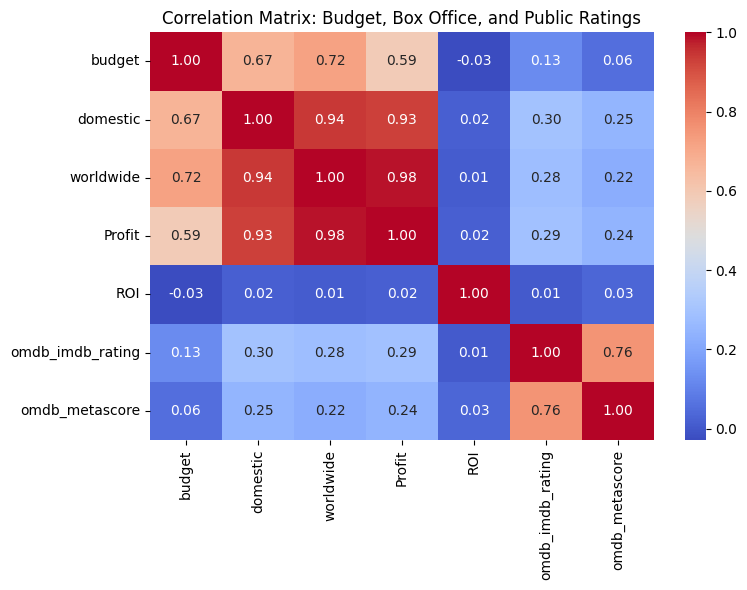

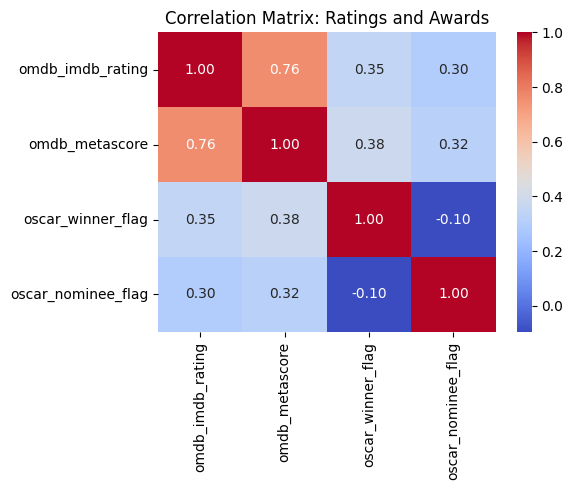

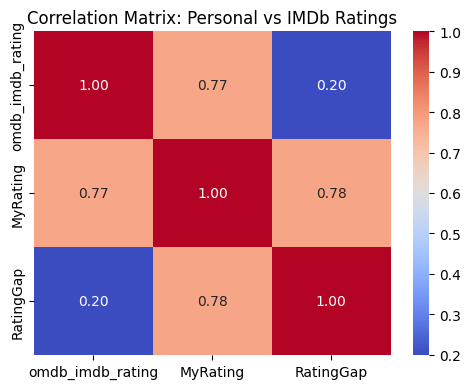

In [ ]:
#1) Core financial + rating variables (hypotheses 1 & 3)
core_corr_cols = []
for col in ["budget", "domestic", "worldwide", "Profit", "ROI",
            "omdb_imdb_rating", "omdb_metascore"]:
    if col in movies_df.columns:
        core_corr_cols.append(col)

core_corr = movies_df[core_corr_cols].corr()

plt.figure(figsize=(8, 6))
# Generated with ChatGPT (LLM): structured heatmap separating financial and rating variables
sns.heatmap(core_corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix: Budget, Box Office, and Public Ratings")
plt.tight_layout()
plt.show()

#2) Ratings + awards (hypothesis 2
awards_corr_cols = []
for col in ["omdb_imdb_rating", "omdb_metascore",
            "oscar_winner_flag", "oscar_nominee_flag"]:
    if col in movies_df.columns:
        awards_corr_cols.append(col)

awards_corr = movies_df[awards_corr_cols].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(awards_corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix: Ratings and Awards")
plt.tight_layout()
plt.show()

# 3) Personal vs public ratings (hypothesis 4)
personal_corr_cols = []
for col in ["omdb_imdb_rating", "MyRating", "RatingGap"]:
    if col in movies_df.columns:
        personal_corr_cols.append(col)

personal_corr = movies_df[personal_corr_cols].corr()

plt.figure(figsize=(5, 4))
sns.heatmap(personal_corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix: Personal vs IMDb Ratings")
plt.tight_layout()
plt.show()

##6. Visualizations

### 6.1 Budget vs IMDb Rating (Log Scale)

This scatter plot examines whether higher movie budgets are associated with higher IMDb ratings. The budget axis is displayed on a logarithmic scale to better visualize the large spread between low-budget films and major studio productions. Each point represents a film, colored by its award level (No Major Awards, Oscar Nominee, Oscar Winner).

**Key Observations:**
- High-budget films (toward the right side of the plot) tend to cluster between IMDb scores of 6.5 and 8.5, indicating that very large productions rarely receive extremely low ratings.
- Lower-budget films show much wider variability, ranging from poorly rated to critically acclaimed.
- Award-winning films (especially Oscar Winners) cluster in the upper-right region, indicating both higher budgets and higher ratings.
- Despite these patterns, there is no strict linear relationship — many mid-budget and low-budget films achieve strong ratings, showing that budget alone does not determine audience reception.


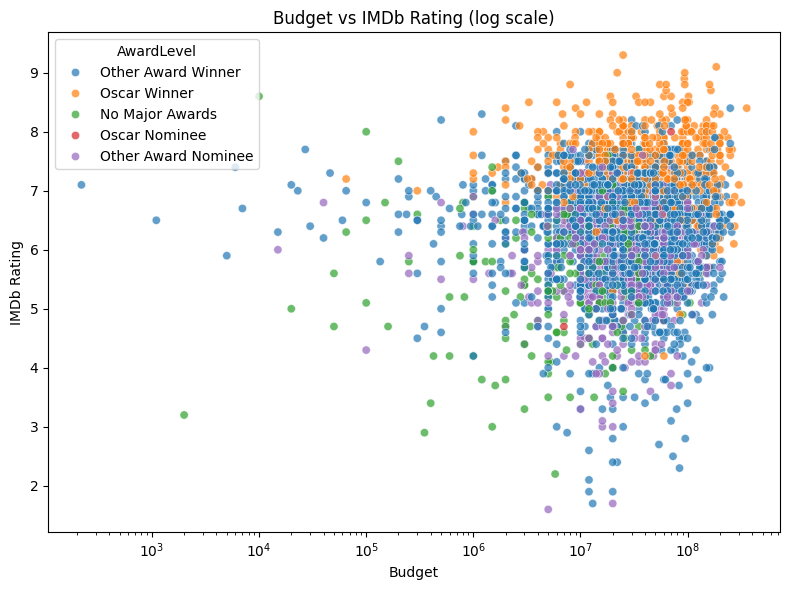

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=movies_df,
    x="budget",
    y="omdb_imdb_rating",
    hue="AwardLevel",
    alpha=0.7 #opacity
)
plt.xscale("log")
plt.title("Budget vs IMDb Rating (log scale)")
plt.xlabel("Budget")
plt.ylabel("IMDb Rating")
plt.tight_layout()
plt.show()

### 6.2 Box Office vs Ratings

This scatter plot explores the relationship between worldwide box-office performance and IMDb ratings, colored by award level (e.g., No Major Awards, Oscar Nominee, Oscar Winner).

**Key Observations:**
- Higher-grossing films tend to maintain IMDb ratings above ~6.5, with fewer poorly rated blockbusters.
- Award-winning films generally appear in the upper-right region of the plot, indicating both higher ratings and higher earnings.
- The wide spread among mid-grossing films suggests that box-office success alone does not guarantee strong ratings.
- Logarithmic scaling highlights the dense clustering of mid-range box office values.


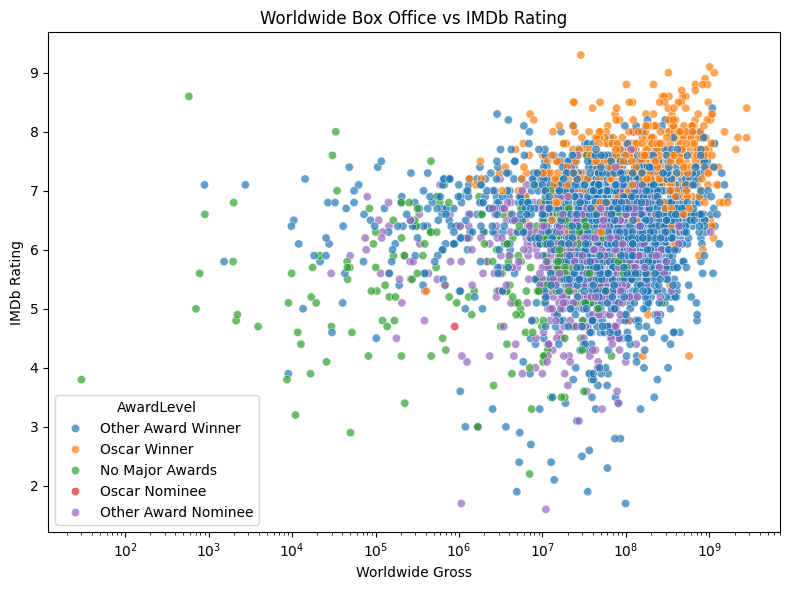

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=movies_df,
    x="worldwide",
    y="omdb_imdb_rating",
    hue="AwardLevel",
    alpha=0.7
)
plt.xscale("log")
plt.title("Worldwide Box Office vs IMDb Rating")
plt.xlabel("Worldwide Gross")
plt.ylabel("IMDb Rating")
plt.tight_layout()
plt.show()

### 6.3 Awards vs Ratings (Boxplots)

This section compares ratings across different award levels using boxplots for both IMDb rating and Metascore. Award groups typically include No Major Awards, Oscar Nominee, and Oscar Winner.

**Key Observations:**
- Oscar-winning films show the highest median IMDb ratings, followed by Oscar nominees.
- Films without major awards tend to have lower median ratings and wider variability.
- Metascore boxplots show an even stronger separation between award categories, indicating that professional critics reward award-winning films more consistently than the general audience.
- Outliers appear in every group, reflecting that awards are not the sole determinant of rating outcomes.


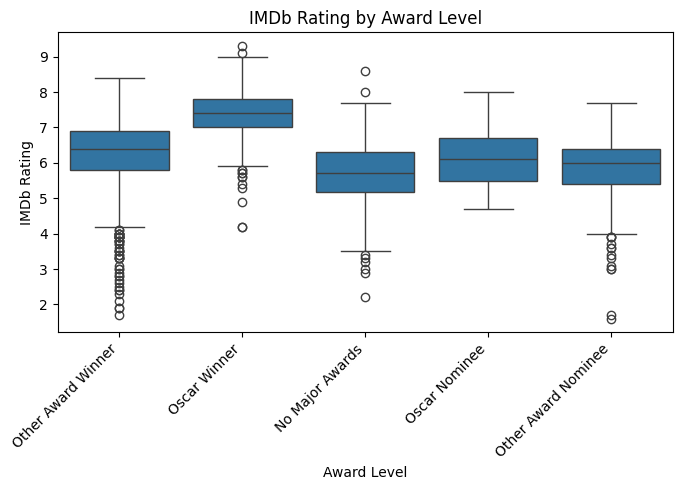

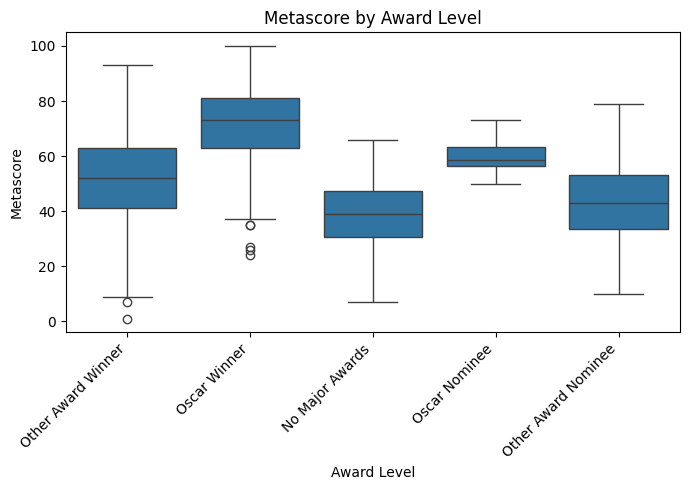

In [ ]:
plt.figure(figsize=(7, 5))
sns.boxplot(data=movies_df, x="AwardLevel", y="omdb_imdb_rating")
plt.xticks(rotation=45, ha='right') # Generated with ChatGPT (LLM): rotate x-axis labels to prevent overlaps and improve readability.
plt.title("IMDb Rating by Award Level")
plt.xlabel("Award Level")
plt.ylabel("IMDb Rating")
plt.tight_layout()
plt.show()

if "omdb_metascore" in movies_df.columns:
    plt.figure(figsize=(7, 5))
    sns.boxplot(data=movies_df, x="AwardLevel", y="omdb_metascore")
    plt.xticks(rotation=45, ha='right') # Generated with ChatGPT (LLM): rotate x-axis labels to prevent overlaps and improve readability.
    plt.title("Metascore by Award Level")
    plt.xlabel("Award Level")
    plt.ylabel("Metascore")
    plt.tight_layout()
    plt.show()

### 6.4 Personal vs Public Ratings

This visualization compares your personal ratings (`MyRating`) with public IMDb ratings, with points colored by award status.

**Key Observations:**
- My ratings tend to follow the general trend of IMDb ratings but show wider personal variability.
- Award-winning films cluster more tightly in the upper rating range for both my ratings and IMDb’s.
- Several films rated highly by me but rated lower by IMDb suggest strong individual preferences independent of mainstream consensus.
- Conversely, popular IMDb favorites that I scored lower indicate divergence between personal taste and public opinion.


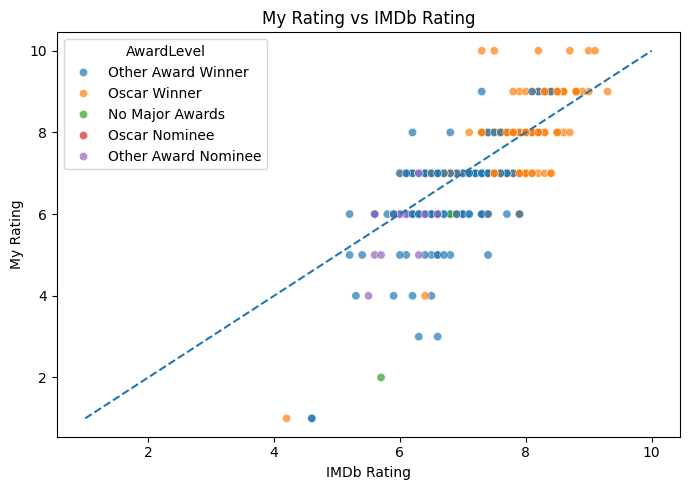

In [ ]:


if "MyRating" in movies_df.columns and "omdb_imdb_rating" in movies_df.columns:
    plt.figure(figsize=(7, 5))

    # Generated with ChatGPT (LLM): added a 45° reference line to visualize agreement
    # between MyRating and IMDbRating by plotting y = x across the shared rating range.
    min_val = min(movies_df["omdb_imdb_rating"].min(), movies_df["MyRating"].min())
    max_val = max(movies_df["omdb_imdb_rating"].max(), movies_df["MyRating"].max())

    plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")
    sns.scatterplot(
        data=movies_df,
        x="omdb_imdb_rating",
        y="MyRating",
        hue="AwardLevel",
        alpha=0.7
    )
    plt.title("My Rating vs IMDb Rating")
    plt.xlabel("IMDb Rating")
    plt.ylabel("My Rating")
    plt.tight_layout()
    plt.show()

### 7. Summary of Exploratory Data Analysis (EDA)

This exploratory analysis examined how film characteristics including budget, worldwide gross revenue, award status, and rating metrics relate to one another across a large multi-source movie dataset. After merging and cleaning several datasets (Box Office Mojo, OMDb, and personal IMDb ratings), we produced a unified movie-level table suitable for statistical testing and visualization.

**Data Cleaning and Preprocessing:**

- Converted financial variables (Budget, DomesticGross, WorldwideGross) into numeric form and removed corrupted or missing entries.
- Standardized rating variables from IMDb, Metascore, and personal ratings.
- Created additional features such as Profit and ROI to evaluate financial performance.
- Ensured consistent merging across multiple identifiers (movie_id, imdb_id) and filtered unrealistic or incomplete entries.

**Descriptive Statistics:**

- Budgets and grosses showed extreme right-skewness, with a small set of very high-budget films driving the upper tail.
- Ratings (IMDb, Metascore) exhibited relatively tight distributions centered around mid-to-high values.
- Award categories (Winner, Nominee, No Award) displayed clear differences in central tendency, with winners generally having higher ratings.

**Correlation Analysis:**

- Correlation analysis showed **very weak positive correlations** between budget and ratings, but **strong correlations** among the financial variables themselves (budget, domestic, worldwide, profit).
- Worldwide gross showed similarly weak correlations with IMDb and Metascore, indicating that commercial success does not strongly predict critical reception.
- Stronger correlations appeared within financial variables themselves (Budget ↔ WorldwideGross, Profit ↔ ROI), reflecting expected economic relationships.

**Visualizations:**

- Scatterplots of Budget vs Ratings (log-scaled budgets) showed wide dispersion, illustrating that both low-budget and high-budget films can achieve strong ratings.
- Boxplots across award categories highlighted clear separation, with Oscar winners outperforming nominees and non-awarded films.
- Histograms and density plots displayed skewed financial distributions but relatively symmetric rating distributions.
- Correlation heatmaps provided an intuitive overview of key variable relationships, confirming patterns observed in statistical tests.

**Overall Insight:**

The EDA suggests that while financial variables (budget, revenue) shape the economic profile of a film, they have **limited predictive power for audience or critic ratings**. Awards, however, show a clearer association with higher ratings. This indicates that film quality is influenced far more by creative and artistic factors than by production scale or box-office performance.
